# Fitting elliptical dataset with Levenberg–Marquardt Optimization

    Project:  PM1
    Author:   Hans-Henrik Fuxelius
    Date:     2022-09-27
    File:     lm_fit_ellipse.ipynb
    Descr:    Exploring the ellipse as a scaled and rotated
              circle and a fast gradient descent solver
    Ref:      https://en.wikipedia.org/wiki/Levenberg–Marquardt_algorithm  
              https://en.wikipedia.org/wiki/MINPACK  
              https://scipy-cookbook.readthedocs.io/items/Least_Squares_Circle.html

The theory behind these experiments is the fact that an ellipse can be viewed as scaled, rotated and transposed circle. This opens up for very efficient algorithms for transforming a common dataset from an magnetometer that can have an elliptical form due to soft or hard iron that skews the dataset from a circle to an ellipse.  
    
    1) rotate
    2) scale
    3) fit
    4) back rotate

In [1]:
import numpy as np
from scipy import optimize, stats
from matplotlib import pyplot as plt

## Circle

In [2]:
# Creating equally spaced data points in range 0 to 2*pi
samples = 30
theta = np.linspace(0, 2 * np.pi, samples)

# Setting radiuses and center points
alfa = 45
Rx = 4
Ry = 4
Cx = 5  
Cy = 5  

# Generating x and y data
xc_vec = Rx * np.cos(theta) * np.cos(alfa) - Ry * np.sin(theta) * np.sin(alfa) + Cx
yc_vec = Rx * np.cos(theta) * np.sin(alfa) + Ry * np.sin(theta) * np.cos(alfa) + Cy

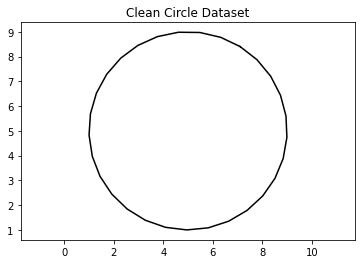

In [3]:
# Plotting
plt.title('Clean Circle Dataset')
plt.axis('equal')
plt.plot(xc_vec, yc_vec, color='black')
plt.show()

## Create a noice vector

In [4]:
noice = 0.3
x_noice = noice * np.random.normal(size=samples)
y_noice = noice * np.random.normal(size=samples)

## Adding noice to circle

In [5]:
# Noice
xc_vec_noice = xc_vec + x_noice
yc_vec_noice = yc_vec + y_noice

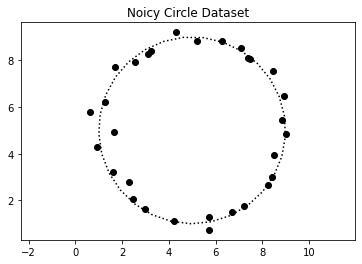

In [6]:
# Plotting
plt.title('Noicy Circle Dataset')
plt.axis('equal')
plt.plot(xc_vec, yc_vec, color='black', linestyle='dotted')
plt.plot(xc_vec_noice, yc_vec_noice, 'o', color='black')
plt.show()

# Ellipsoid

In [7]:
# Setting radiuses and center points
alfa = 45
Rx = 6
Ry = 4
Cx = 52    
Cy = 177    

# Generating x and y data
xe_vec = Rx * np.cos(theta) * np.cos(alfa) - Ry * np.sin(theta) * np.sin(alfa) + Cx
ye_vec = Rx * np.cos(theta) * np.sin(alfa) + Ry * np.sin(theta) * np.cos(alfa) + Cy

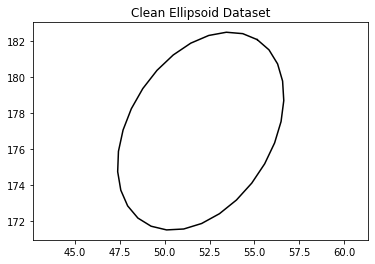

In [8]:
# Plotting
plt.title('Clean Ellipsoid Dataset')
plt.axis('equal')
plt.plot(xe_vec, ye_vec, color='black')
plt.show()

## Add noise to the 2D elliptical dataset 

In [9]:
# Add noise to the data
xe_noice = xe_vec + x_noice
ye_noice = ye_vec + y_noice

In [10]:
# Add outliers
xe_noice = np.append(xe_noice, 40)
ye_noice = np.append(ye_noice, 170)

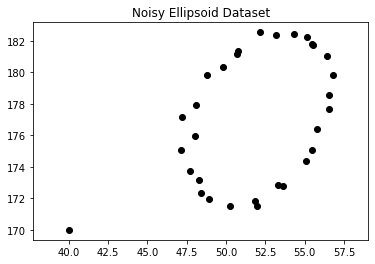

In [11]:
# Plotting
plt.title('Noisy Ellipsoid Dataset')
plt.axis('equal')
plt.plot(xe_noice, ye_noice, 'o', color='black')
plt.show()

### Distribution

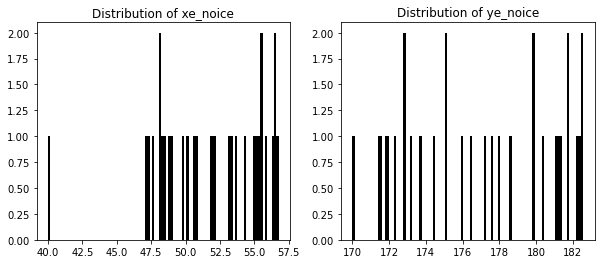

In [12]:
fig = plt.figure()

fig.set_figheight(4)
fig.set_figwidth(10)

# Adds subplot on position 1
ax1 = fig.add_subplot(121)
plt.title('Distribution of xe_noice')
plt.hist(xe_noice, bins=100, color='black')

# Adds subplot on position 2
ax2 = fig.add_subplot(122)
plt.title('Distribution of ye_noice')
plt.hist(ye_noice, bins=100, color='black')

plt.show()

### Filtering

In [13]:
xe_mean = xe_noice.mean()
ye_mean = ye_noice.mean()

xe_mean, ye_mean

(51.71604594576852, 176.99317847810462)

In [14]:
xe_std = xe_noice.std()
ye_std = ye_noice.std()

xe_std, ye_std

(3.84790537815331, 4.036173789961718)

In [15]:
# Simple filter for far outliers of dataset (x,y)
def filter(x, y, factor = 2.0): 
    x_mean = x.mean()
    x_std  = x.std()
    
    y_mean = y.mean()
    y_std  = y.std()
    
    # Operator precedence does not work proper in NumPy!
    x_filter = (x > (x_mean - factor*x_std)) & (x < (x_mean + factor*x_std))
    y_filter = (y > (y_mean - factor*y_std)) & (y < (y_mean + factor*y_std))
    
    xf = x[x_filter & y_filter]
    yf = y[x_filter & y_filter]
    
    return xf, yf

In [16]:
# Filtering
xe_filter, ye_filter = filter(xe_noice, ye_noice)

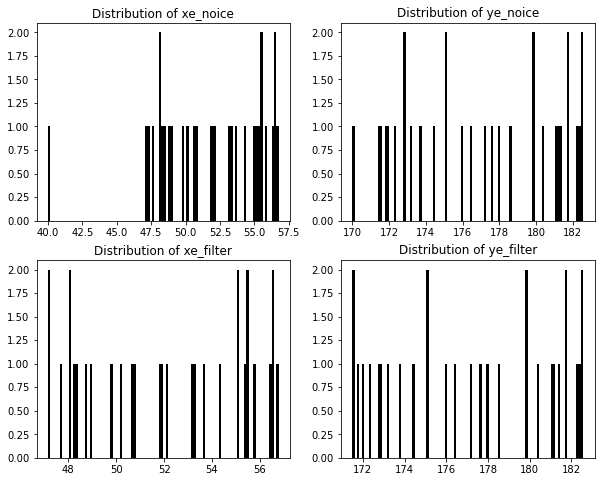

In [17]:
fig = plt.figure()

fig.set_figheight(8)
fig.set_figwidth(10)

# Adds subplot on position 1
ax1 = fig.add_subplot(221)
plt.title('Distribution of xe_noice')
plt.hist(xe_noice, bins=100, color='black')

# Adds subplot on position 2
ax2 = fig.add_subplot(222)
plt.title('Distribution of ye_noice')
plt.hist(ye_noice, bins=100, color='black')

# Adds subplot on position 1
ax1 = fig.add_subplot(223)
plt.title('Distribution of xe_filter')
plt.hist(xe_filter, bins=100, color='black')

# Adds subplot on position 2
ax2 = fig.add_subplot(224)
plt.title('Distribution of ye_filter')
plt.hist(ye_filter, bins=100, color='black')

plt.show()

# Levenberg–Marquardt Optimization 

In [18]:
#  Matrix rotation
def rotate(alfa, x, y):
    x_rot = x * np.cos(alfa) - y * np.sin(alfa)
    y_rot = x * np.sin(alfa) + y * np.cos(alfa)
    return x_rot, y_rot

In [19]:
# Levenberg–Marquardt Optimization
# by gradient descent and Gauss-Newton
# x, y is numpy vectors of data points
# x_m, y_m is first guess of center (0,0)
# theta_m is first guess of rotation (0)
# scale_m is first guess of scaling (1)
def ellipse(x, y, x_m, y_m, alfa_m, scale_m):

    # calculate the distance of each 2D points from the center (xc, yc)
    # 1) Rotate x,y 
    # 2) scale only y-axis
    def residuals(xc, yc, alfa, scale):
        x_rot, y_rot = rotate(alfa, x, y)
        y_scale = scale * y_rot
        return np.sqrt((x_rot - xc)**2 + (y_scale - yc)**2)

    
    # calculate the algebraic distance between the data points and the 
    # mean circle centered at c=(xc, yc)
    def f(p):
        xc, yc, alfa, scale = p
        ri = residuals(xc, yc, alfa, scale)
        return ri - ri.mean()
    
    # initial guess for the fit parameters
    p0 = (x_m, y_m, alfa_m, scale_m)
    
    p, ier = optimize.leastsq(f, p0)

    xc, yc, alfa, scale = p
    
    # Map alfa -> [-pi, pi]
    alfa = np.arctan2(np.sin(alfa), np.cos(alfa))
    
    ri       = residuals(xc, yc, alfa, scale)
    r        = ri.mean()
    resid    = np.sum((ri - r)**2)
    
    # Error as ratio between resid and radius
    error    = np.sqrt(resid / x.shape[0]) / r

    return xc, yc, alfa, scale, r, error

In [20]:
# Use lm_fit to get meta parameters for analysis that a full circle has been used
# These parameters are then used to extract (x,y) -> (theta_pol, r_pol) 
def fit(x, y):
    # Dataset (x,y) must first be normalized by (x-x_mean, y-y_mean)
    # for the algorithm to converge with confidence inside circle
    # or ellipsoid
    x_mean = x.mean()
    y_mean = y.mean()
    
    # Center dataset to x,y-mean
    x_cent = x - x_mean
    y_cent = y - y_mean
    
    # Minimization. x_m=0, y_m=0, alfa_m=0, scale_m=1
    xc, yc, alfa, scale, r, error = ellipse(x_cent, y_cent, 0, 0, 0, 1)

    return x_mean, y_mean, xc, yc, alfa, scale, r, error

In [21]:
x_mean, y_mean, xc, yc, alfa, scale, r, error = fit(xe_filter, ye_filter)

## Show estimation results

In [22]:
print(f'''
x_mean={x_mean}
y_mean={y_mean}

xc={xc}
yc={yc}
radius={r}
alfa={alfa}
scale={scale}
error={error}\n''')


x_mean=52.10658081062748
y_mean=177.22628442737476

xc=-0.021182622242437426
yc=0.11750446336060491
radius=3.9571572713543386
alfa=-2.5958345739108792
scale=0.6621759890252079
error=0.04961849100248278



In [23]:
# Parameters are then used to extract (x,y) -> (theta_pol, r_pol)
def extract(x, y, x_mean, y_mean, xc, yc, alfa, scale, r):

    # Center dataset to x,y-mean
    x_cent = x - x_mean
    y_cent = y - y_mean
    
    # 1) Back rotate (xc, yc) as for the fitted dataset 
    xc_est, yc_est = rotate(-alfa, xc, yc)
    
    # 2) Run residuals function explicitly for x,y dataset
    x_rot, y_rot = rotate(alfa, x_cent, y_cent)
    y_scale = scale * y_rot
    
    # 3) Back rotate dataset
    x_est, y_est = rotate(-alfa, x_rot, y_scale)

    # Normalized dataset to unit circle
    # Center = (0,0)
    # Radius = 1
    x_norm = (x_est - xc_est) / r
    y_norm = (y_est - yc_est) / r
    
    # Convert to polar coordinates
    theta_pol = np.arctan2(y_norm, x_norm)
    r_pol = np.sqrt(x_norm**2 + y_norm**2)

    return theta_pol, r_pol    

### Extract filtered dataset for further analysis of segments

In [24]:
theta_analysis, r_analysis = extract(xe_filter, ye_filter, x_mean, y_mean, xc, yc, alfa, scale, r)

### Extract the real dataset

In [25]:
theta_pol, r_pol = extract(xe_noice, ye_noice, x_mean, y_mean, xc, yc, alfa, scale, r)

### Plot the results

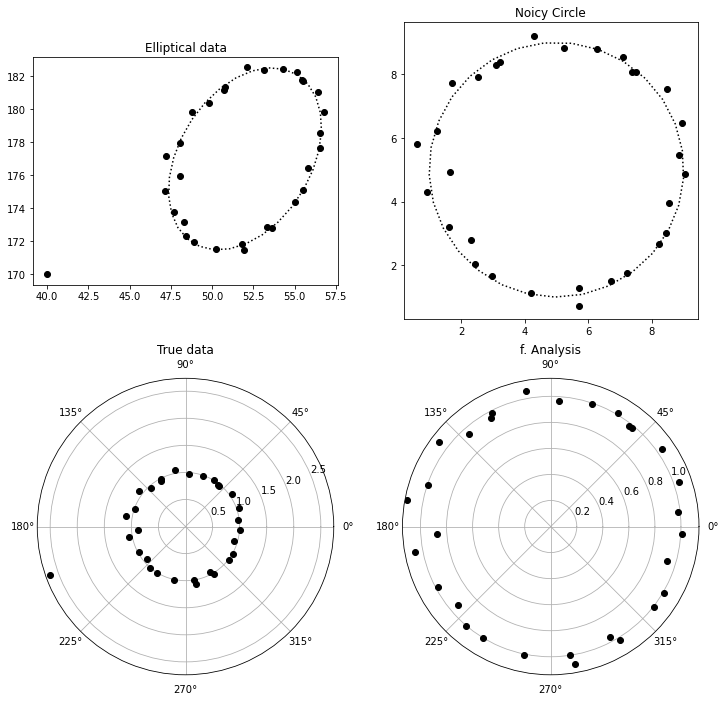

In [26]:
fig = plt.figure()

fig.set_figheight(12)
fig.set_figwidth(12)

# Adds subplot on position 1
ax2 = fig.add_subplot(221)
ax2.set_aspect('equal')
ax2.title.set_text('Elliptical data')
plt.plot(xe_vec, ye_vec, color='black', linestyle='dotted')
plt.plot(xe_noice, ye_noice, 'o', color='black')

# Adds subplot on position 2
ax1 = fig.add_subplot(222)
ax1.set_aspect('equal')
ax1.title.set_text('Noicy Circle')
plt.plot(xc_vec, yc_vec, color='black', linestyle='dotted')
plt.plot(xc_vec_noice, yc_vec_noice, 'o', color='black')

# Adds subplot on position 3
ax3 = fig.add_subplot(223, polar=True)
ax3.title.set_text('True data')
ax3.plot(theta_pol, r_pol, 'o', color='black')

# Adds subplot on position 4
ax3 = fig.add_subplot(224, polar=True)
ax3.title.set_text('f. Analysis')
ax3.plot(theta_analysis, r_analysis, 'o', color='black')

plt.show()


NOTE: The noice was added in two steps individually, first to the circle and second to the ellipse. So the noicy circle is not fully comparable to the other two pictures. It is only there for comparison that rotation of the dataset works correctly. From the unit circle the heading and quality can be directly derived as *f(theta,r)*

### Meta Analysis

The meta data can be splined through out the dataset and used for normalizing and transforming data

### Testing distribution of final set for analysis

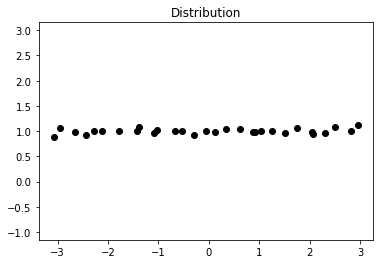

In [27]:
# Plotting
plt.plot(theta_analysis, r_analysis, 'o', color='black')
plt.axis('equal')
plt.title('Distribution')
plt.show()

In [28]:
# Circle Analysis
#
# Check how even the distribution is over f.ex. 10 bins
# Ideal return is: (1,0,1)
def c_anal(theta, r,  bucket=10, fill=1):
    bins = np.linspace(-np.pi, np.pi, bucket+1)
    d, _ = np.histogram(theta, bins)
    
    # print(d)
    
    # Check that all bins have >= fill values
    bin_count = np.ones(bucket)[d >= fill].sum()  
    bin_fill = bin_count / bucket
    
    # Chi2 p_value comapares fill between buckets
    # All buckets equal filled => 1.0
    pvalue = stats.chisquare(d)[1]
    
    # Test centricity of r (radius) vector
    # =0 is perfect centricity
    # >0 means less good centricity
    centricity = np.sqrt(np.sum((1-r)**2)) / r.shape[0]
    
    return bin_fill, centricity, pvalue 

In [29]:
c_anal(theta_analysis, r_analysis, fill=3)

(0.8, 0.009059055597142313, 0.9982046941194037)